In [3]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array

def neighbors_distances(universe, cutoff_distance, center_index):
    "Finds carbon neighbors within a cutoff distance."
    center_atom = universe.atoms[center_index]
    if center_atom.name != 'C':
        return []  # Not a carbon atom

    carbon_atoms = universe.select_atoms("name C")  # Select only carbon atoms
    neighbor_atoms = carbon_atoms.select_atoms(f"around {cutoff_distance} index {center_index}")

    neighbors = []
    for atom in neighbor_atoms:
        if atom.index != center_index:  # Exclude the center atom itself
            dist = distance_array(center_atom.position, atom.position).item()  # Extract single value
            neighbors.append(dist)
    print(neighbors)
    
    #print(f"Atom {center_index} has {len(neighbors)} neighbors: {neighbors}")
    return neighbors

# Main:
analized_prote = input("quin fitxer de proteïna vols analitzar? ")
u = mda.Universe("dades/" + analized_prote)
cutoff_distance = 10
distances_vector = []

print(f"Total atoms: {len(u.atoms)}")

for i in range(10):
    distances_vector.extend(neighbors_distances(u, cutoff_distance, i))

quin fitxer de proteïna vols analitzar?  a


ValueError: '' isn't a valid topology format, nor a coordinate format
   from which a topology can be minimally inferred.
   You can use 'Universe(topology, ..., topology_format=FORMAT)'
   to explicitly specify the format and
   override automatic detection. Known FORMATs are:
   dict_keys(['PSF', 'TOP', 'PRMTOP', 'PARM7', 'PDB', 'ENT', 'XPDB', 'PQR', 'GRO', 'CRD', 'PDBQT', 'DMS', 'TPR', 'MOL2', 'DATA', 'LAMMPSDUMP', 'XYZ', 'TXYZ', 'ARC', 'GMS', 'CONFIG', 'HISTORY', 'XML', 'MMTF', 'GSD', 'MINIMAL', 'ITP', 'IN', 'FHIAIMS', 'PARMED', 'RDKIT', 'OPENMMTOPOLOGY', 'OPENMMAPP'])
   See https://docs.mdanalysis.org/documentation_pages/topology/init.html#supported-topology-formats
   For missing formats, raise an issue at 
   https://github.com/MDAnalysis/mdanalysis/issues

In [2]:
print(distances_vector)

NameError: name 'distances_vector' is not defined

In [1]:
def histogram(hist_data, hist_name, save, save_title):
    """
    prints and saves a histogram with the given distribution
    """
    hist_data = np.array(hist_data)
    
    fig, ax = plt.subplots()
    bin_edges = np.linspace(0, cutoff_distance, 41)
    ax.hist(hist_data, bins=bin_edges)
    # plot the xdata locations on the x axis:
    ax.set_ylabel("Nombre de "+ hist_name+" a aquesta distància")
    ax.set_xlabel("Distància")
    plt.title(save_title)
    if save == True:
        plt.savefig(save_title+".png", dpi=1000, bbox_inches='tight')

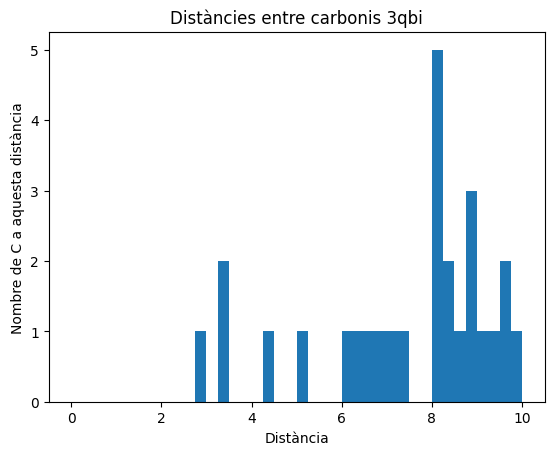

In [5]:
histogram(distances_vector, "C", True, "Distàncies entre carbonis "+analized_prote.removesuffix(".pdb"))

Analyzing structure: dades/3qbi.pdb
Number of carbon atoms selected: 2844
Found 34038 carbon-carbon distances between 0.001 and 5 Angstroms.
Example short distances (first 10): [4.45422622 4.80919904 4.57699846 3.78302356 1.53550537 1.51637835
 4.64045397 1.51637835 3.64533363 3.276265  ]
Average short distance: 3.79 Å
All 34038 distances saved to: distance_plots/carbon_carbon_short_distances.txt
KDE plot saved to: distance_plots/carbon_distance_kde_3qbi.pdf


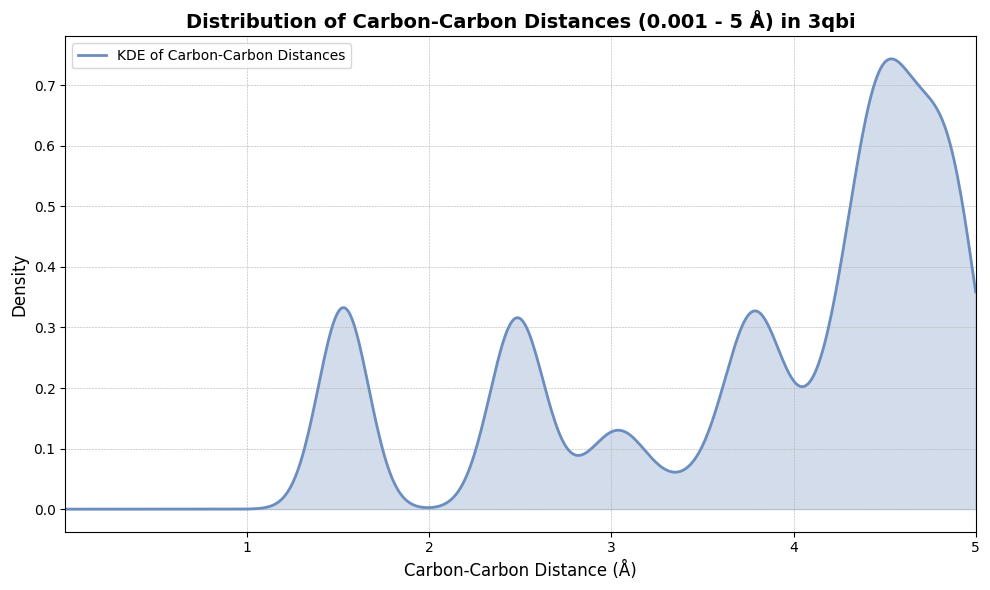

In [9]:
#Single plots

import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os


try:
    universe = mda.Universe('dades/3qbi.pdb')
except FileNotFoundError:
    print("Error: The PDB file was not found. Please provide the correct path to your .pdb file.")
    exit()

# Select all carbon atoms
carbon_atoms = universe.select_atoms("name C CA CB CG CD CE CF CH CZ or name c ca cb cg cd ce cf ch cz")

# Define the cutoff distance
cutoff_distance = 5 # Angstroms

# Define output directory for plots and data
output_directory = "distance_plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

print(f"Analyzing structure: {universe.filename}")
print(f"Number of carbon atoms selected: {len(carbon_atoms)}")

if len(carbon_atoms) < 2:
    print("Not enough carbon atoms selected to calculate pairwise distances (need at least 2).")
else:
    # Use capped_distance for efficient calculation of distances below the cutoff
    results = distances.capped_distance(
        carbon_atoms.positions,
        carbon_atoms.positions,
        min_cutoff=0.001,
        max_cutoff=cutoff_distance,
        box=universe.dimensions
    )

    # ***CRITICAL FIX: Use results[1] for distances, as identified by debug output***
    # The debug output showed results[1] contains the scalar distances,
    # while results[0] contained the index pairs.
    short_distances_np = np.array(results[1])

    if short_distances_np.size > 0:
        print(f"Found {short_distances_np.size} carbon-carbon distances between 0.001 and {cutoff_distance} Angstroms.")
        print(f"Example short distances (first 10): {short_distances_np[:10]}")
        print(f"Average short distance: {np.mean(short_distances_np):.2f} Å")

        # --- Save the actual distances to a file ---
        distances_file_path = os.path.join(output_directory, "carbon_carbon_short_distances.txt")
        np.savetxt(distances_file_path, short_distances_np, fmt='%.4f', header='Carbon-Carbon Distances (Angstroms)', comments='# ')
        print(f"All {short_distances_np.size} distances saved to: {distances_file_path}")

        # --- KDE Plotting for Distances ---
        fig, ax = plt.subplots(figsize=(10, 6))

        kde_x_range = np.linspace(0.001, cutoff_distance, 500)

        if short_distances_np.size > 1 and np.std(short_distances_np) > 1e-9:
            try:
                kde_data = short_distances_np.reshape(1, -1)
                kde = gaussian_kde(kde_data)
                kde_y = kde(kde_x_range)

                ax.plot(kde_x_range, kde_y, color='#6c8ebf', linewidth=2, label="KDE of Carbon-Carbon Distances")
                ax.fill_between(kde_x_range, kde_y, color='#6c8ebf', alpha=0.3)

            except ValueError as e:
                print(f"KDE plot could not be generated due to an error: {e}. Falling back to line plot if applicable.")
                if short_distances_np.size > 0:
                    ax.axvline(short_distances_np[0].item() if short_distances_np.ndim == 0 else short_distances_np[0],
                               color='red', linestyle='--',
                               label=f'Distance: {short_distances_np[0].item() if short_distances_np.ndim == 0 else short_distances_np[0]:.2f} Å (KDE not generated)')
        else:
            print("Not enough unique short distances to create a meaningful KDE plot.")
            if short_distances_np.size > 0:
                ax.axvline(short_distances_np[0].item() if short_distances_np.ndim == 0 else short_distances_np[0],
                           color='red', linestyle='--',
                           label=f'Distance: {short_distances_np[0].item() if short_distances_np.ndim == 0 else short_distances_np[0]:.2f} Å (KDE not generated)')


        ax.set_xlabel("Carbon-Carbon Distance (Å)", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        pdb_filename_clean = universe.filename.split('/')[-1].replace('.pdb', '')
        ax.set_title(f"Distribution of Carbon-Carbon Distances (0.001 - {cutoff_distance} Å) in {pdb_filename_clean}", fontsize=14, weight='bold')

        ax.set_xlim(0.001, cutoff_distance)
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend()

        plt.tight_layout()
        output_plot_path = os.path.join(output_directory, f"carbon_distance_kde_{pdb_filename_clean}.pdf")
        plt.savefig(output_plot_path)
        print(f"KDE plot saved to: {output_plot_path}")

        plt.show()
        plt.close()

    else:
        print(f"No carbon-carbon distances between 0.001 and {cutoff_distance} Angstroms were found to plot or save.")


--- Processing Protein A ---
Analyzing structure: dades/9cah.pdb
Number of carbon atoms selected for 9cah.pdb: 3645
Found 39394 carbon-carbon distances in 9cah.pdb between 0.001 and 5 Angstroms.
Average short distance for 9cah.pdb: 3.68 Å

--- Processing Protein B ---
Analyzing structure: dades/9cah_pred.pdb
Number of carbon atoms selected for 9cah_pred.pdb: 3645
Found 41364 carbon-carbon distances in 9cah_pred.pdb between 0.001 and 5 Angstroms.
Average short distance for 9cah_pred.pdb: 3.74 Å


/Users/deumenec/myenv/TFGenv/lib/python3.13/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"



Comparison KDE plot saved to: distance_comparison_plots/9cah CC distance.pdf


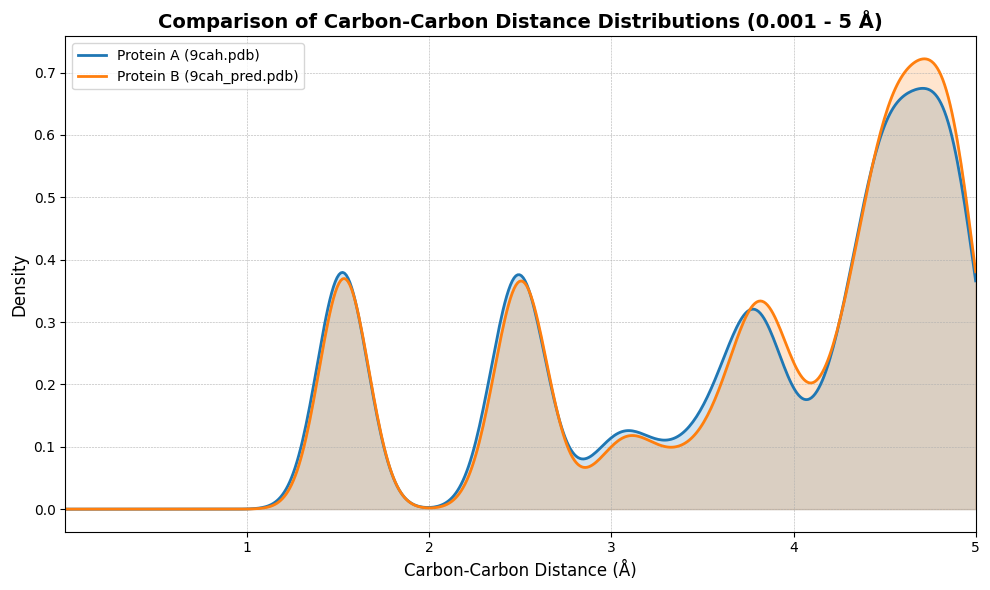

In [16]:
#Multiple plots
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

def get_carbon_carbon_distances(pdb_file_path, cutoff_distance):
    """
    Loads a PDB file, selects all specified carbon atoms, and calculates
    carbon-carbon distances within a given cutoff.

    Args:
        pdb_file_path (str): Path to the PDB file.
        cutoff_distance (float): Maximum distance (in Angstroms) to consider.

    Returns:
        np.ndarray: An array of carbon-carbon distances. Returns an empty
                    array if the file is not found or if no distances are found.
    """
    try:
        # Load the protein structure
        universe = mda.Universe(pdb_file_path)
    except FileNotFoundError:
        print(f"Error: The PDB file '{pdb_file_path}' was not found. Please provide the correct path.")
        return np.array([]) # Return empty array if file not found
    except Exception as e:
        print(f"Error loading PDB file '{pdb_file_path}': {e}")
        return np.array([])

    # Select all carbon atoms based on common naming conventions
    # This selection matches your original code's comprehensive list
    carbon_atoms = universe.select_atoms("name C CA CB CG CD CE CF CH CZ or name c ca cb cg cd ce cf ch cz")

    print(f"Analyzing structure: {universe.filename}")
    print(f"Number of carbon atoms selected for {os.path.basename(pdb_file_path)}: {len(carbon_atoms)}")

    if len(carbon_atoms) < 2:
        print(f"Not enough carbon atoms selected in {os.path.basename(pdb_file_path)} to calculate pairwise distances (need at least 2).")
        return np.array([])

    # Use capped_distance for efficient calculation of distances below the cutoff
    # min_cutoff is set to a small value to exclude self-distances (0)
    results = distances.capped_distance(
        carbon_atoms.positions,
        carbon_atoms.positions,
        min_cutoff=0.001,
        max_cutoff=cutoff_distance,
        box=universe.dimensions
    )

    # results[1] contains the scalar distances from capped_distance
    short_distances_np = np.array(results[1])

    if short_distances_np.size > 0:
        print(f"Found {short_distances_np.size} carbon-carbon distances in {os.path.basename(pdb_file_path)} "
              f"between 0.001 and {cutoff_distance} Angstroms.")
        print(f"Average short distance for {os.path.basename(pdb_file_path)}: {np.mean(short_distances_np):.2f} Å")
    else:
        print(f"No carbon-carbon distances found in {os.path.basename(pdb_file_path)} "
              f"between 0.001 and {cutoff_distance} Angstroms.")

    return short_distances_np

# --- Main part of the script for comparison ---


# Define the PDB file paths
name = "9cah"

protein_a_file = "dades/"+name+ ".pdb"
protein_b_file = "dades/"+name +"_pred.pdb"

# Define the cutoff distance (same for both proteins for fair comparison)
cutoff_distance = 5 # Angstroms

# Define output directory for plots
output_directory = "distance_comparison_plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

print("\n--- Processing Protein A ---")
distances_protein_a = get_carbon_carbon_distances(protein_a_file, cutoff_distance)

print("\n--- Processing Protein B ---")
distances_protein_b = get_carbon_carbon_distances(protein_b_file, cutoff_distance)

# --- Plotting the KDEs for both proteins ---
fig, ax = plt.subplots(figsize=(10, 6))

# Define a common range for KDE x-axis to ensure comparability
kde_x_range = np.linspace(0.001, cutoff_distance, 500)

plot_generated = False # Flag to check if at least one KDE plot was generated

# Plot for Protein A
if distances_protein_a.size > 1 and np.std(distances_protein_a) > 1e-9:
    try:
        # Reshape for gaussian_kde if necessary, though it often handles 1D arrays
        kde_a_data = distances_protein_a.reshape(1, -1)
        kde_a = gaussian_kde(kde_a_data)
        kde_y_a = kde_a(kde_x_range)
        ax.plot(kde_x_range, kde_y_a, color='#1f77b4', linewidth=2, label=f'Protein A ({os.path.basename(protein_a_file)})')
        ax.fill_between(kde_x_range, kde_y_a, color='#1f77b4', alpha=0.2)
        plot_generated = True
    except ValueError as e:
        print(f"KDE plot for Protein A could not be generated: {e}. Data might be too uniform or sparse.")
else:
    print(f"Not enough unique distances in {os.path.basename(protein_a_file)} to create a meaningful KDE plot.")
    if distances_protein_a.size > 0:
        ax.axvline(distances_protein_a[0].item() if distances_protein_a.ndim == 0 else distances_protein_a[0],
                   color='#1f77b4', linestyle=':', label=f'Single distance in A: {distances_protein_a[0]:.2f} Å')

# Plot for Protein B
if distances_protein_b.size > 1 and np.std(distances_protein_b) > 1e-9:
    try:
        kde_b_data = distances_protein_b.reshape(1, -1)
        kde_b = gaussian_kde(kde_b_data)
        kde_y_b = kde_b(kde_x_range)
        ax.plot(kde_x_range, kde_y_b, color='#ff7f0e', linewidth=2, label=f'Protein B ({os.path.basename(protein_b_file)})')
        ax.fill_between(kde_x_range, kde_y_b, color='#ff7f0e', alpha=0.2)
        plot_generated = True
    except ValueError as e:
        print(f"KDE plot for Protein B could not be generated: {e}. Data might be too uniform or sparse.")
else:
    print(f"Not enough unique distances in {os.path.basename(protein_b_file)} to create a meaningful KDE plot.")
    if distances_protein_b.size > 0:
        ax.axvline(distances_protein_b[0].item() if distances_protein_b.ndim == 0 else distances_protein_b[0],
                   color='#ff7f0e', linestyle=':', label=f'Single distance in B: {distances_protein_b[0]:.2f} Å')

if plot_generated:
    ax.set_xlabel("Carbon-Carbon Distance (Å)", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(f"Comparison of Carbon-Carbon Distance Distributions (0.001 - {cutoff_distance} Å)", fontsize=14, weight='bold')

    ax.set_xlim(0.001, cutoff_distance)
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)

    # Add legend only if there are handles (i.e., plots were added)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=10)

    plt.tight_layout()
    output_plot_path = os.path.join(output_directory, name+" CC distance.pdf")
    plt.savefig(output_plot_path)
    print(f"\nComparison KDE plot saved to: {output_plot_path}")
    plt.show()
else:
    print("\nNo plots were generated. Check your PDB files and data sizes.")

plt.close(fig) # Ensure the figure is closed



--- Processing Protein A ---
Analyzing structure: dades/3qbi.pdb
Number of oxygen atoms selected for 3qbi.pdb: 778
Number of nitrogen atoms selected for 3qbi.pdb: 778
Found 3883 oxygen-nitrogen distances in 3qbi.pdb between 0.001 and 5 Angstroms.
Average short distance for 3qbi.pdb: 3.28 Å

--- Processing Protein B ---
Analyzing structure: dades/3qbi_pred.pdb
Number of oxygen atoms selected for 3qbi_pred.pdb: 778
Number of nitrogen atoms selected for 3qbi_pred.pdb: 778
Found 3843 oxygen-nitrogen distances in 3qbi_pred.pdb between 0.001 and 5 Angstroms.
Average short distance for 3qbi_pred.pdb: 3.28 Å

Comparison KDE plot saved to: distance_comparison_plots/3qbi_ON_distance_comparison.pdf


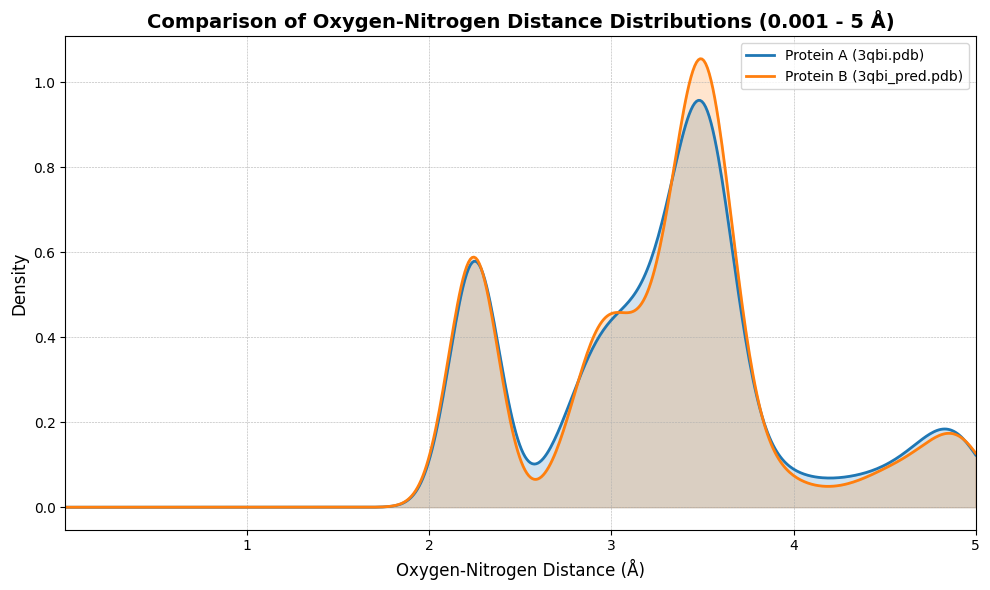

In [20]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

def get_oxygen_nitrogen_distances(pdb_file_path, cutoff_distance):
    """
    Loads a PDB file, selects oxygen and nitrogen atoms, and calculates
    distances specifically between oxygen atoms and nitrogen atoms within a given cutoff.
    Excludes O-O and N-N distances.

    Args:
        pdb_file_path (str): Path to the PDB file.
        cutoff_distance (float): Maximum distance (in Angstroms) to consider.

    Returns:
        np.ndarray: An array of oxygen-nitrogen distances. Returns an empty
                    array if the file is not found or if no distances are found.
    """
    try:
        # Load the protein structure
        universe = mda.Universe(pdb_file_path)
    except FileNotFoundError:
        print(f"Error: The PDB file '{pdb_file_path}' was not found. Please provide the correct path.")
        return np.array([]) # Return empty array if file not found
    except Exception as e:
        print(f"Error loading PDB file '{pdb_file_path}': {e}")
        return np.array([])

    # Select only oxygen atoms based on common naming conventions
    oxygen_atoms = universe.select_atoms("name O or name o")
    # Select only nitrogen atoms based on common naming conventions
    nitrogen_atoms = universe.select_atoms("name N or name n")

    print(f"Analyzing structure: {universe.filename}")
    print(f"Number of oxygen atoms selected for {os.path.basename(pdb_file_path)}: {len(oxygen_atoms)}")
    print(f"Number of nitrogen atoms selected for {os.path.basename(pdb_file_path)}: {len(nitrogen_atoms)}")


    # Check if there are enough atoms in both groups to calculate distances between them
    if len(oxygen_atoms) == 0 or len(nitrogen_atoms) == 0:
        print(f"Not enough oxygen or nitrogen atoms selected in {os.path.basename(pdb_file_path)} to calculate O-N distances.")
        return np.array([])

    # Use capped_distance to calculate distances BETWEEN oxygen and nitrogen atoms
    # We pass oxygen_atoms.positions as the first group and nitrogen_atoms.positions as the second.
    # This ensures only O-N distances are calculated, not O-O or N-N.
    results = distances.capped_distance(
        oxygen_atoms.positions,  # Group 1: Oxygen atoms
        nitrogen_atoms.positions, # Group 2: Nitrogen atoms
        min_cutoff=0.001,
        max_cutoff=cutoff_distance,
        box=universe.dimensions
    )

    # results[1] contains the scalar distances from capped_distance
    short_distances_np = np.array(results[1])

    if short_distances_np.size > 0:
        print(f"Found {short_distances_np.size} oxygen-nitrogen distances in {os.path.basename(pdb_file_path)} "
              f"between 0.001 and {cutoff_distance} Angstroms.")
        print(f"Average short distance for {os.path.basename(pdb_file_path)}: {np.mean(short_distances_np):.2f} Å")
    else:
        print(f"No oxygen-nitrogen distances found in {os.path.basename(pdb_file_path)} "
              f"between 0.001 and {cutoff_distance} Angstroms.")

    return short_distances_np

# --- Main part of the script for comparison ---

# Define the PDB file paths
name = "3qbi" # Your base name for the PDB files

protein_a_file = "dades/" + name + ".pdb"
protein_b_file = "dades/" + name + "_pred.pdb"

# Define the cutoff distance (same for both proteins for fair comparison)
cutoff_distance = 5 # Angstroms

# Define output directory for plots
output_directory = "distance_comparison_plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

print("\n--- Processing Protein A ---")
distances_protein_a = get_oxygen_nitrogen_distances(protein_a_file, cutoff_distance)

print("\n--- Processing Protein B ---")
distances_protein_b = get_oxygen_nitrogen_distances(protein_b_file, cutoff_distance)

# --- Plotting the KDEs for both proteins ---
fig, ax = plt.subplots(figsize=(10, 6))

# Define a common range for KDE x-axis to ensure comparability
kde_x_range = np.linspace(0.001, cutoff_distance, 500)

plot_generated = False # Flag to check if at least one KDE plot was generated

# Plot for Protein A
if distances_protein_a.size > 1 and np.std(distances_protein_a) > 1e-9:
    try:
        # Reshape for gaussian_kde if necessary, though it often handles 1D arrays
        kde_a_data = distances_protein_a.reshape(1, -1)
        kde_a = gaussian_kde(kde_a_data)
        kde_y_a = kde_a(kde_x_range)
        ax.plot(kde_x_range, kde_y_a, color='#1f77b4', linewidth=2, label=f'Protein A ({os.path.basename(protein_a_file)})')
        ax.fill_between(kde_x_range, kde_y_a, color='#1f77b4', alpha=0.2)
        plot_generated = True
    except ValueError as e:
        print(f"KDE plot for Protein A could not be generated: {e}. Data might be too uniform or sparse.")
else:
    print(f"Not enough unique distances in {os.path.basename(protein_a_file)} to create a meaningful KDE plot.")
    if distances_protein_a.size > 0:
        ax.axvline(distances_protein_a[0].item() if distances_protein_a.ndim == 0 else distances_protein_a[0],
                   color='#1f77b4', linestyle=':', label=f'Single distance in A: {distances_protein_a[0]:.2f} Å')

# Plot for Protein B
if distances_protein_b.size > 1 and np.std(distances_protein_b) > 1e-9:
    try:
        kde_b_data = distances_protein_b.reshape(1, -1)
        kde_b = gaussian_kde(kde_b_data)
        kde_y_b = kde_b(kde_x_range)
        ax.plot(kde_x_range, kde_y_b, color='#ff7f0e', linewidth=2, label=f'Protein B ({os.path.basename(protein_b_file)})')
        ax.fill_between(kde_x_range, kde_y_b, color='#ff7f0e', alpha=0.2)
        plot_generated = True
    except ValueError as e:
        print(f"KDE plot for Protein B could not be generated: {e}. Data might be too uniform or sparse.")
else:
    print(f"Not enough unique distances in {os.path.basename(protein_b_file)} to create a meaningful KDE plot.")
    if distances_protein_b.size > 0:
        ax.axvline(distances_protein_b[0].item() if distances_protein_b.ndim == 0 else distances_protein_b[0],
                   color='#ff7f0e', linestyle=':', label=f'Single distance in B: {distances_protein_b[0]:.2f} Å')

if plot_generated:
    ax.set_xlabel("Oxygen-Nitrogen Distance (Å)", fontsize=12) # Updated label
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(f"Comparison of Oxygen-Nitrogen Distance Distributions (0.001 - {cutoff_distance} Å)", fontsize=14, weight='bold') # Updated title

    ax.set_xlim(0.001, cutoff_distance)
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)

    # Add legend only if there are handles (i.e., plots were added)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=10)

    plt.tight_layout()
    # Updated output file name
    output_plot_path = os.path.join(output_directory, name + "_ON_distance_comparison.pdf")
    plt.savefig(output_plot_path)
    print(f"\nComparison KDE plot saved to: {output_plot_path}")
    plt.show()
else:
    print("\nNo plots were generated. Check your PDB files and data sizes.")

plt.close(fig) # Ensure the figure is closed
